In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.3
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
matplotlib 3.5.1
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.6.3
keras.api._v2.keras 2.6.0


In [2]:
%pip install py7zr
import py7zr
a = py7zr.SevenZipFile(r'../input/cifar-10/train.7z','r')
a.extractall(path=r'./')
a.close()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 3.2 MB/s eta 0:00:0000:0100:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 34.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 KB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 5.5 MB/s eta 0:00:00
  Created wheel for py7zr: filename=py7zr-0.18.5-py3-none-any.whl size=67393 sha256=cf5b2129df31b97824ea05ae694de05b5823ca3dcd8af1a1f169489b12dfb23d
  Stored in directory: /root/.cache/pip/wheels/c8/f6/f8/9a860b95b853b2a891d478d2d2afde2fc0460514a7015d15d5
Successfully built py

In [3]:
b = py7zr.SevenZipFile(r'../input/cifar-10/test.7z','r')
b.extractall(path=r'./')
b.close()

In [4]:
!ls

__notebook_source__.ipynb  test  train


In [5]:
!ls ..

input  lib  working


## 输入数据处理

In [6]:
# 所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

# 路径
train_labels_file = '../input/cifar-10/trainLabels.csv'  # labels
test_csv_file = '../input/cifar-10/sampleSubmission.csv'  # submission
train_folder = './train/'  # 训练集所在的文件夹
test_folder = './test/'  # 测试集所在的文件夹

# def parse_csv_file(filepath, folder):
#     """Parses csv files into (filename(path), label) format"""
#     results = []
#     # 读取所有行
#     with open(filepath, 'r') as f:
# #         lines = f.readlines()  为什么加[1:]？ 有标题head
#         lines = f.readlines()[1:]
#     for line in lines:
#         image_id, label_str = line.strip('\n').split(',')
#         image_full_path = os.path.join(folder, image_id + '.png')
#         results.append((image_full_path, label_str))
#     return results

# # 解析对应的文件夹
# train_labels_info = parse_csv_file(train_lables_file, train_folder)
# test_csv_info = parse_csv_file(test_csv_file, test_folder)

# # 打印
# import pprint
# pprint.pprint(train_labels_info[0:5])
# pprint.pprint(test_csv_info[0:5])
# print(len(train_labels_info), len(test_csv_info))

# 读取 label
train_path_df = pd.read_csv(train_labels_file)
train_path_df["id"] = train_path_df["id"].apply(lambda x: "{}/{}.png".format(train_folder, x))
train_path_df.columns=["filepath", "class"]
train_path_df.head()

test_df = pd.read_csv(test_csv_file)
test_df["id"] = test_df["id"].apply(lambda x: "{}/{}.png".format(test_folder, x))
test_df.columns=["filepath", "class"]
test_df.head()

,filepath,class
0,./test//1.png,cat
1,./test//2.png,cat
2,./test//3.png,cat
3,./test//4.png,cat
4,./test//5.png,cat


In [7]:
# # train_df = pd.DataFrame(train_labels_info)
# train_df = pd.DataFrame(train_labels_info[0:45000])
# valid_df = pd.DataFrame(train_labels_info[45000:])
# test_df = pd.DataFrame(test_csv_info)

# train_df.columns = ['filepath', 'class']
# valid_df.columns = ['filepath', 'class']
# test_df.columns = ['filepath', 'class']

# print(train_df.head())
# print(valid_df.head())
# print(test_df.head())

In [8]:
# 数据集划分
train_df = pd.DataFrame(train_path_df[0:45000])
valid_df = pd.DataFrame(train_path_df[45000:])

## 模型搭建

In [9]:
height = 224
width = 224
channels = 3
batch_size = 24
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    # 将labels转换为id
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',
)

# 和上面一致
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
   preprocessing_function = keras.applications.resnet50.preprocess_input)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [10]:
model = keras.models.Sequential([
    keras.applications.ResNet50(include_top=False, pooling='avg', weights='imagenet'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.layers[0].trainable = True
model.summary()

2022-05-07 03:31:31.432469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 03:31:31.522921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 03:31:31.523764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 03:31:31.525761: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


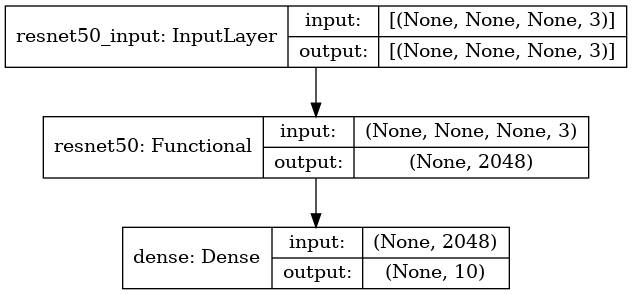

In [11]:
keras.utils.plot_model(model, show_shapes=True)

## 模型训练与预测

In [12]:
epochs = 20
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_num // batch_size,
                              epochs = epochs,
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-05-07 03:31:39.799423: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-07 03:31:45.720275: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1875/1875 [==============================] - 618s 323ms/step - loss: 1.3696 - accuracy: 0.5122 - val_loss: 1.3513 - val_accuracy: 0.5705
Epoch 2/20
1875/1875 [==============================] - 605s 323ms/step - loss: 0.8932 - accuracy: 0.6888 - val_loss: 0.9743 - val_accuracy: 0.6745
Epoch 3/20
1875/1875 [==============================] - 606s 323ms/step - loss: 0.7201 - accuracy: 0.7486 - val_loss: 0.6612 - val_accuracy: 0.7706
Epoch 4/20
1875/1875 [==============================] - 605s 323ms/step - loss: 0.6204 - accuracy: 0.7858 - val_loss: 0.6944 - val_accuracy: 0.7682
Epoch 5/20
1875/1875 [==============================] - 606s 323ms/step - loss: 0.5612 - accuracy: 0.8065 - val_loss: 0.6596 - val_accuracy: 0.7909
Epoch 6/20
1875/1875 [==============================] - 604s 322ms/step - loss: 0.5015 - accuracy: 0.8264 - val_loss: 0.4184 - val_accuracy: 0.8622
Epoch 7/20
1875/1875 [==============================] - 612s 326ms/step - loss: 0.4520 - accuracy: 0.8442 - val_loss: 0.518

{'loss': [1.3695789575576782, 0.8932397365570068, 0.7201477885246277, 0.6204202771186829, 0.5611846446990967, 0.5014836192131042, 0.45200902223587036, 0.42821428179740906, 0.3908670246601105, 0.36657392978668213, 0.3456652760505676, 0.3210827112197876, 0.2983771562576294, 0.2815881371498108, 0.27158233523368835, 0.2563270330429077, 0.24412007629871368, 0.23524576425552368, 0.22029007971286774, 0.21094967424869537], 'accuracy': [0.5121999979019165, 0.6888222098350525, 0.7485777735710144, 0.7857778072357178, 0.8064888715744019, 0.8264222145080566, 0.8441555500030518, 0.8501111268997192, 0.864133358001709, 0.8727999925613403, 0.8812666535377502, 0.8877999782562256, 0.8952000141143799, 0.9015555381774902, 0.9041110873222351, 0.9110666513442993, 0.9147555828094482, 0.9181555509567261, 0.9242444634437561, 0.9256222248077393], 'val_loss': [1.351306676864624, 0.9742769002914429, 0.6611746549606323, 0.6943697333335876, 0.6596279144287109, 0.4183897376060486, 0.5188820958137512, 0.44506391882896

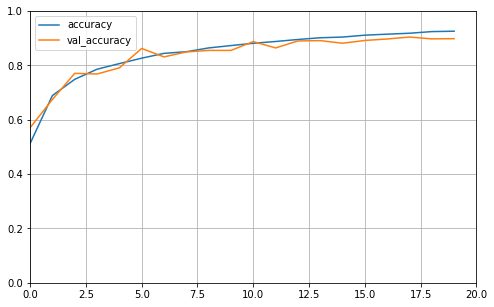

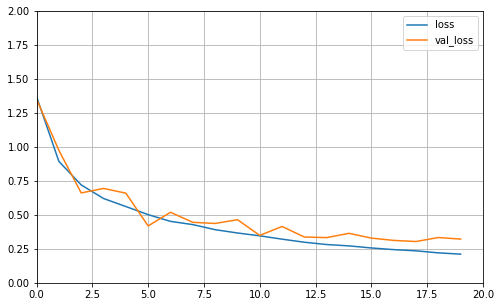

In [13]:
print(history.history)
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [14]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input)
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [15]:
# 正式预测
test_predict = model.predict_generator(test_generator,
                                       workers = 3,
                                       use_multiprocessing = True)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [16]:
print(test_predict.shape)

(300000, 10)


In [17]:
print(test_predict[0:5])

[[2.05844012e-03 4.30648681e-03 2.11397279e-03 2.07194928e-02
  7.93787558e-03 2.39449466e-04 6.08552682e-06 1.46988581e-03
  1.02614320e-03 9.60122228e-01]
 [6.40150249e-01 3.06324847e-03 3.28885345e-03 3.10947269e-01
  3.00106057e-03 2.99139749e-02 4.32986999e-05 3.23812469e-06
  5.82049647e-03 3.76828550e-03]
 [1.88894688e-07 9.99893665e-01 8.52322923e-09 1.27717197e-08
  3.84311111e-10 1.38865808e-10 5.73199133e-09 3.69262815e-10
  9.88398874e-09 1.06087784e-04]
 [2.36134474e-06 4.34783516e-08 4.83464078e-08 2.84059798e-09
  1.45220502e-10 4.12235190e-10 1.43810536e-11 3.53994091e-11
  9.99997497e-01 1.22271893e-09]
 [9.99832988e-01 2.12919016e-08 1.07837106e-04 3.98885095e-05
  1.09425409e-05 6.95835433e-06 6.06584251e-07 6.22784100e-08
  2.30600605e-07 4.48500373e-07]]


## 预测结果提交

In [18]:
test_predict_class_indices = np.argmax(test_predict, axis = 1)

In [19]:
print(test_predict_class_indices[0:5])

[9 0 1 8 0]


In [20]:
test_predict_class = [class_names[index] 
                      for index in test_predict_class_indices]

In [21]:
print(test_predict_class[0:5])

['truck', 'airplane', 'automobile', 'ship', 'airplane']


In [22]:
# 产生最终的报告
def generate_submissions(filename, predict_class):
    with open(filename, 'w') as f:
        f.write('id,label\n')
        for i in range(len(predict_class)):
            f.write('%d,%s\n' % (i+1, predict_class[i]))

# output_file = "../cifar10/submission_resnet50.csv"
output_file = "./submission_resnet50.csv"
generate_submissions(output_file, test_predict_class)